## This notebook required GPU and should be run within ChromBPNet docker environment

In [34]:
### Please make sure to download models from XXX 

In [ ]:
### These environments are installed within docker: 
!pip install jupyterlab
!pip install pysam
!conda install -c bioconda pandas -y
!conda install -c bioconda logomaker -y 
!conda install -c bioconda seaborn -y 
!pip install hdf5plugin

In [1]:
## Load packages 
import tensorflow as tf
import numpy as np
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
import logomaker
from copy import deepcopy
from tqdm import tqdm
from tqdm import tnrange
import pyBigWig
import tqdm
import sys
import pyfaidx
sys.path.append("../../../chrombpnet/")
from training.utils.losses import multinomial_nll
from training.utils.one_hot import dna_to_one_hot
from evaluation.interpret.shap_utils import *
import shap
import glob
tf.compat.v1.disable_eager_execution()
from scipy.spatial.distance import jensenshannon
from numpy.linalg import norm
from scipy.stats import wasserstein_distance
import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib
import hdf5plugin
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import h5py
import pyBigWig
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import sys
sys.path.append("../../../src/")
custom_objects={"tf":tf, "multinomial_nll":multinomial_nll}    
get_custom_objects().update(custom_objects)
from tensorflow import keras
import deepdish as dd
from scipy.stats import pearsonr
from scipy.stats import spearmanr

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

## Functions

In [2]:
### Required functions 
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

In [3]:
def dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(np.int8)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))

In [4]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

In [5]:
def generate_shap_dict(seqs, scores):
    print(seqs.shape, scores.shape)
    assert(seqs.shape==scores.shape)
    assert(seqs.shape[2]==4)

    # construct a dictionary for the raw shap scores and the
    # the projected shap scores
    # MODISCO workflow expects one hot sequences with shape (None,4,inputlen)
    d = {
            'raw': {'seq': np.transpose(seqs, (0, 2, 1))},
            'shap': {'seq': np.transpose(scores, (0, 2, 1))},
            'projected_shap': {'seq': np.transpose(seqs*scores, (0, 2, 1))}
        }

    return d

In [6]:
from deeplift.dinuc_shuffle import dinuc_shuffle

def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    
    for l in [0]:
        projected_hypothetical_contribs = \
            np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        
        # At each position in the input sequence, we iterate over the
        # one-hot encoding possibilities (eg: for genomic sequence, 
        # this is ACGT i.e. 1000, 0100, 0010 and 0001) and compute the
        # hypothetical difference-from-reference in each case. We then 
        # multiply the hypothetical differences-from-reference with 
        # the multipliers to get the hypothetical contributions. For 
        # each of the one-hot encoding possibilities, the hypothetical
        # contributions are then summed across the ACGT axis to 
        # estimate the total hypothetical contribution of each 
        # position. This per-position hypothetical contribution is then
        # assigned ("projected") onto whichever base was present in the
        # hypothetical sequence. The reason this is a fast estimate of
        # what the importance scores *would* look like if different 
        # bases were present in the underlying sequence is that the
        # multipliers are computed once using the original sequence, 
        # and are not computed again for each hypothetical sequence.
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:, i] = 1.0
            hypothetical_difference_from_reference = \
                (hypothetical_input[None, :, :] - bg_data[l])
            hypothetical_contribs = hypothetical_difference_from_reference * \
                                    mult[l]
            projected_hypothetical_contribs[:, :, i] = \
                np.sum(hypothetical_contribs, axis=-1) 
            
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))

    if len(orig_inp)>1:
        to_return.append(np.zeros_like(orig_inp[1]))
    
    return to_return


def shuffle_several_times(s):
    numshuffles=20
    if len(s)==2:
        return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)]),
                np.array([s[1] for i in range(numshuffles)])]
    else:
        return [np.array([dinuc_shuffle(s[0]) for i in range(numshuffles)])]

In [7]:
def get_weightedsum_meannormed_logits(model):
    # Assumes the 0 task track is for profile
    # See Google slide deck for explanations
    # We meannorm as per section titled 
    # "Adjustments for Softmax Layers" in the DeepLIFT paper
    meannormed_logits = (model.outputs[0] - \
                         tf.reduce_mean(model.outputs[0], axis=1)[:, None])

    # 'stop_gradient' will prevent importance from being propagated
    # through this operation; we do this because we just want to treat
    # the post-softmax probabilities as 'weights' on the different 
    # logits, without having the network explain how the probabilities
    # themselves were derived. Could be worth contrasting explanations
    # derived with and without stop_gradient enabled...
    stopgrad_meannormed_logits = tf.stop_gradient(meannormed_logits)
    softmax_out = tf.nn.softmax(stopgrad_meannormed_logits, axis=1)
    
    # Weight the logits according to the softmax probabilities, take
    # the sum for each example. This mirrors what was done for the
    # bpnet paper.
    weightedsum_meannormed_logits = tf.reduce_sum(softmax_out * \
                                                  meannormed_logits,
                                                  axis=1)
    
    return weightedsum_meannormed_logits

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def ic_scale(pwm,background):
    odds_ratio = ((pwm+0.001)/(1.004))/(background[None,:])
    ic = ((np.log((pwm+0.001)/(1.004))/np.log(2))*pwm -\
            (np.log(background)*background/np.log(2))[None,:])
    return pwm*(np.sum(ic,axis=1)[:,None])


def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(matplotlib.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(matplotlib.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(matplotlib.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
def plot_weights_given_ax(ax, array,
                 height_padding_factor,
                 length_padding,
                 subticks_frequency,
                 highlight,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 ylabel="",
                 ylim=None):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                matplotlib.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))

    if ylim is not None:
        # Use user-specified y-axis limits
        min_neg_height, max_pos_height = ylim
        assert min_neg_height <= 0
        assert max_pos_height >= 0

    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=1.0,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={},
                 ylabel="",
                 ylim=None,
                 filename=None,
                 return_fig=False):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_weights_given_ax(ax=ax, array=array,
        height_padding_factor=height_padding_factor,
        length_padding=length_padding,
        subticks_frequency=subticks_frequency,
        colors=colors,
        plot_funcs=plot_funcs,
        highlight=highlight,
        ylabel=ylabel,
        ylim=ylim)
    plt.ylim(ylim)
    plt.savefig(filename,format="svg")

    if return_fig:
        return fig
    plt.show()

In [9]:
def calculate_correlations(array1, array2):
    correlations = np.zeros(array1.shape[0])
    
    for i in range(array1.shape[0]):
        corr, _ = pearsonr(array1[i], array2[i])
        correlations[i] = corr
    
    return correlations

In [10]:
from collections import Counter

def find_common_peaks(peaks):
    # Count occurrences of each peak
    peak_counts = Counter(peaks)

    # Filter peaks that occur at least twice
    common_peaks = [peak for peak, count in peak_counts.items() if count >= 2]

    return common_peaks


def merge_lists(lists):
    merged_list = []
    for lst in lists:
        merged_list.extend(lst)
    return merged_list

In [11]:
def generate_onehot_sequences(genome_fasta_path,peaks_with_summit):
    ref = pyfaidx.Fasta(genome_fasta_path)
    INPUT_LEN = 2114
    sequences = []
    buffer = 500
    for i,x in peaks_with_summit.iterrows():
        sequence = str(ref[x['peak_chrom']][((x['peak_start'] + x['summit']) - INPUT_LEN//2):((x['peak_start'] + x['summit']) + INPUT_LEN//2)])
        if len(sequence)==2114:
            sequence = sequence[:INPUT_LEN]
            sequences.append(sequence)
        else: 
            print(i)
    onehot_seq = []
    for i in range(len(sequences)):
        onehot_seq.append(dna_to_one_hot(sequences[i]).reshape(1,-1,4))

    onehot_seq = np.concatenate( onehot_seq, axis=0 )
    print(onehot_seq.shape)
    return onehot_seq

In [12]:
input_len = 2114
start = np.int(input_len/2 - 500)
end = np.int(input_len/2 + 500)
def compute_and_save_shap_scores(species_model,onehot_seq):
    model_profile_explainers = shap.explainers.deep.TFDeepExplainer(
    (species_model.input, get_weightedsum_meannormed_logits(species_model)),
    shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
    profile_shap_scores = np.array(model_profile_explainers.shap_values(
    onehot_seq, progress_message=200))
    profile_shap_scores_dict = generate_shap_dict(onehot_seq, profile_shap_scores)
    profile_shap_scores_dict = profile_shap_scores_dict['projected_shap']['seq'][:]
    profile_shap_scores_dict = profile_shap_scores_dict.transpose(0,2,1)
    profile_shap_scores_dict = np.sum(profile_shap_scores_dict,axis=2)
    profile_shap_scores_dict = profile_shap_scores_dict[:,start:end]
    return profile_shap_scores_dict

/tmp/ipykernel_8435/2963587682.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start = np.int(input_len/2 - 500)
/tmp/ipykernel_8435/2963587682.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; fo

### Loading models 

In [20]:
# Let's now load the two models and run the difference
with tf.keras.utils.CustomObjectScope({'multinomial_null':multinomial_nll, 'tf':tf}):
    Sman_neural = keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/neural/neural_chrombpnet_wo_bias.h5")
    Sman_cathepsin = keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/cathepsin/cathepsin_chrombpnet_wo_bias.h5")
    Sman_intestine = keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/intestine/intestine_chrombpnet_wo_bias.h5")
    Sman_muscle = keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/muscle/muscle_chrombpnet_wo_bias.h5")
    Sman_tegument = keras.models.load_model("./ChromBPNet/chrombpnet_models/Sman/fold_1/tegument/tegument_chrombpnet_wo_bias.h5")
    
    Smed_neural = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/neural/neural_chrombpnet_wo_bias.h5")
    Smed_cathepsin = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/cathepsin/cathepsin_chrombpnet_wo_bias.h5")
    Smed_epidermal = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/epidermal/epidermal_chrombpnet_wo_bias.h5")
    Smed_intestine = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/intestine/intestine_chrombpnet_wo_bias.h5")
    Smed_muscle = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/muscle/muscle_chrombpnet_wo_bias.h5")
    Smed_parenchyma = keras.models.load_model("./ChromBPNet/chrombpnet_models/Smed/fold_1/parenchyma/parenchyma_chrombpnet_wo_bias.h5")
    
    Mlig_neural = keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/neural/neural_chrombpnet_wo_bias.h5")
    Mlig_cathepsin = keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/cathepsin/cathepsin_chrombpnet_wo_bias.h5")
    Mlig_epidermal = keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/epidermal/epidermal_chrombpnet_wo_bias.h5")
    Mlig_intestine = keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/intestine/intestine_chrombpnet_wo_bias.h5")
    Mlig_muscle = keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/muscle/muscle_chrombpnet_wo_bias.h5")
    Mlig_parenchyma = keras.models.load_model("./ChromBPNet/chrombpnet_models/Mlig/fold_1/parenchyma/parenchyma_chrombpnet_wo_bias.h5")

2024-08-05 20:00:12.461397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 20:00:12.462326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 20:00:12.469225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 20:00:12.469934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-05 20:00:12.470601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

## M. lignano

In [55]:
### Loading neural and muscle marker peaks 
neural_peaks = pd.read_csv("./ChromBPNet/Peaks/Mlig_Neural_final.csv",index_col=0)
muscle_peaks = pd.read_csv("./ChromBPNet/Peaks/Mlig_muscle_final.csv",index_col=0)
overlap = intersection(muscle_peaks.Peak, neural_peaks.Peak) 
neural_peaks= neural_peaks[~neural_peaks.Peak.isin(overlap)]
neural_peaks = neural_peaks.sort_values(by='prob_da', ascending=False).head(n=7000)
muscle_peaks = muscle_peaks[~muscle_peaks.Peak.isin(overlap)]


In [56]:
neural_peaks[['chr', 'start', 'end']] = neural_peaks['Peak'].str.split(':|-', expand=True)
muscle_peaks[['chr', 'start', 'end']] = muscle_peaks['Peak'].str.split(':|-', expand=True)


In [57]:
allpeaks = pd.read_csv("./Peaks/Mlig.merged_peaks.narrowPeak", sep="\t",header=None)
allpeaks.columns = ['chr','start','end','peak_index','score','strand','X','Y','Z','summit']
allpeaks =  allpeaks[['chr','start','end','summit']]
allpeaks['Peak'] = allpeaks.chr + ':' + (allpeaks.start+1).astype(str) + '-' + allpeaks.end.astype(str)
allpeaks['start'] = allpeaks['start']+1
allpeaks

,chr,start,end,summit,Peak
0,ML45REF0001,104,253,108,ML45REF0001:104-253
1,ML45REF0001,1623,2063,93,ML45REF0001:1623-2063
2,ML45REF0001,3130,3535,263,ML45REF0001:3130-3535
3,ML45REF0001,7171,7418,134,ML45REF0001:7171-7418
4,ML45REF0001,13231,13993,262,ML45REF0001:13231-13993
...,...,...,...,...,...
236013,ML45REF0415,986,1420,75,ML45REF0415:986-1420
236014,ML45REF0415,3425,3574,69,ML45REF0415:3425-3574
236015,ML45REF0415,5749,6284,142,ML45REF0415:5749-6284
236016,ML45REF0415,7555,7706,70,ML45REF0415:7555-7706


In [58]:
neural_peaks_summit = pd.merge(neural_peaks,allpeaks,on=['Peak'],how='left')
muscle_peaks_summit = pd.merge(muscle_peaks,allpeaks,on=['Peak'],how='left')

neural_peaks_summit = neural_peaks_summit [['chr_y','start_y','end_y','summit','Peak','prob_da','effect_size']]
neural_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','Peak','prob_da','effect_size']
index = [2049,2060,2211,2256] # neural
neural_peaks_summit= neural_peaks_summit.drop(index)

muscle_peaks_summit = muscle_peaks_summit [['chr_y','start_y','end_y','summit','Peak','prob_da','effect_size']]
muscle_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','Peak','prob_da','effect_size']
index = [813,1015,1217,1743] #muscle
muscle_peaks_summit= muscle_peaks_summit.drop(index)

### neural peaks

In [59]:
Mlig_neural_onehot_seq = generate_onehot_sequences('./Refs/Mlig_4_5.v5/Mlig_4_5.fa',neural_peaks_summit)

(6996, 2114, 4)


In [44]:
## Doing predictions 
Mlig_neural = Mlig_neural.predict(Mlig_neural_onehot_seq)
Mlig_cathepsin = Mlig_cathepsin.predict(Mlig_neural_onehot_seq)
Mlig_epidermal = Mlig_epidermal.predict(Mlig_neural_onehot_seq)
Mlig_intestine = Mlig_intestine.predict(Mlig_neural_onehot_seq)
Mlig_muscle = Mlig_muscle.predict(Mlig_neural_onehot_seq)
Mlig_parenchyma = Mlig_parenchyma.predict(Mlig_neural_onehot_seq)

/opt/conda/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-08-05 20:16:04.020919: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [45]:
Mlig_neural_logits, Mlig_neural_counts = Mlig_neural
Mlig_cathepsin_logits, Mlig_cathepsin_counts = Mlig_cathepsin
Mlig_epidermal_logits, Mlig_epidermal_counts = Mlig_epidermal
Mlig_intestine_logits, Mlig_intestine_counts = Mlig_intestine
Mlig_muscle_logits, Mlig_muscle_counts = Mlig_muscle
Mlig_parenchyma_logits, Mlig_parenchyma_counts = Mlig_parenchyma

Mlig_neural_probs = softmax(Mlig_neural_logits) # Mlig neural
Mlig_cathepsin_probs = softmax(Mlig_cathepsin_logits) # Mlig cathepsin 
Mlig_epidermal_probs = softmax(Mlig_epidermal_logits) # Mlig epidermal
Mlig_intestine_probs = softmax(Mlig_intestine_logits) # Mlig intestine
Mlig_muscle_probs = softmax(Mlig_muscle_logits) # Mlig muscle
Mlig_parenchyma_probs = softmax(Mlig_parenchyma_logits) # Mlig parenchyma


In [46]:
# Calcuating correlation for profile 
corr_muscle_profile = calculate_correlations(Mlig_neural_probs,Mlig_muscle_probs)
corr_intestine_profile = calculate_correlations(Mlig_neural_probs, Mlig_intestine_probs)
corr_cathepsin_profile = calculate_correlations(Mlig_neural_probs, Mlig_cathepsin_probs)
corr_epidermal_profile = calculate_correlations(Mlig_neural_probs, Mlig_epidermal_probs)
corr_parenchyma_profile = calculate_correlations(Mlig_neural_probs, Mlig_parenchyma_probs)

In [51]:
Mlig_neural_SHAP = compute_and_save_shap_scores(Mlig_neural, Mlig_neural_onehot_seq)
Mlig_muscle_SHAP = compute_and_save_shap_scores(Mlig_muscle, Mlig_neural_onehot_seq)
Mlig_intestine_SHAP = compute_and_save_shap_scores(Mlig_intestine, Mlig_neural_onehot_seq)
Mlig_cathepsin_SHAP = compute_and_save_shap_scores(Mlig_cathepsin, Mlig_neural_onehot_seq)
Mlig_epidermal_SHAP = compute_and_save_shap_scores(Mlig_epidermal, Mlig_neural_onehot_seq)
Mlig_parenchyma_SHAP = compute_and_save_shap_scores(Mlig_parenchyma, Mlig_neural_onehot_seq)

In [52]:
Mlig_corr_muscle_SHAP = calculate_correlations(Mlig_neural_SHAP, Mlig_muscle_SHAP)
Mlig_corr_intestine_SHAP = calculate_correlations(Mlig_neural_SHAP, Mlig_intestine_SHAP)
Mlig_corr_cathepsin_SHAP = calculate_correlations(Mlig_neural_SHAP, Mlig_cathepsin_SHAP)
Mlig_corr_epidermal_SHAP= calculate_correlations(Mlig_neural_SHAP, Mlig_epdiermal_SHAP)
Mlig_corr_parenchyma_SHAP= calculate_correlations(Mlig_neural_SHAP, Mlig_parenchyma_SHAP)

In [136]:
muscle_df = pd.DataFrame(data=Mlig_corr_muscle_SHAP)
muscle_df['g'] = 'muscle'
muscle_df.columns = ['x','g']

intestine_df = pd.DataFrame(data=Mlig_corr_intestine_SHAP)
intestine_df['g'] = 'intestine'
intestine_df.columns = ['x','g']

cathepsin_df = pd.DataFrame(data=Mlig_corr_cathepsin_SHAP)
cathepsin_df['g'] = 'cathepsin'
cathepsin_df.columns = ['x','g']

tegument_df = pd.DataFrame(data=Mlig_corr_epidermal_SHAP)
tegument_df['g'] = 'tegument'
tegument_df.columns = ['x','g']

parenchyma_df = pd.DataFrame(data=Mlig_corr_parenchyma_SHAP)
parenchyma_df['g'] = 'parenchyma'
parenchyma_df.columns = ['x','g']

df_all = [tegument_df, cathepsin_df, intestine_df,parenchyma_df, muscle_df]
df_all = pd.concat(df_all,axis=0)
df_all

,x,g
0,-0.071779,tegument
1,-0.111153,tegument
2,0.185080,tegument
3,0.067817,tegument
4,0.037455,tegument
...,...,...
6991,0.332445,muscle
6992,0.395546,muscle
6993,0.190751,muscle
6994,0.002340,muscle


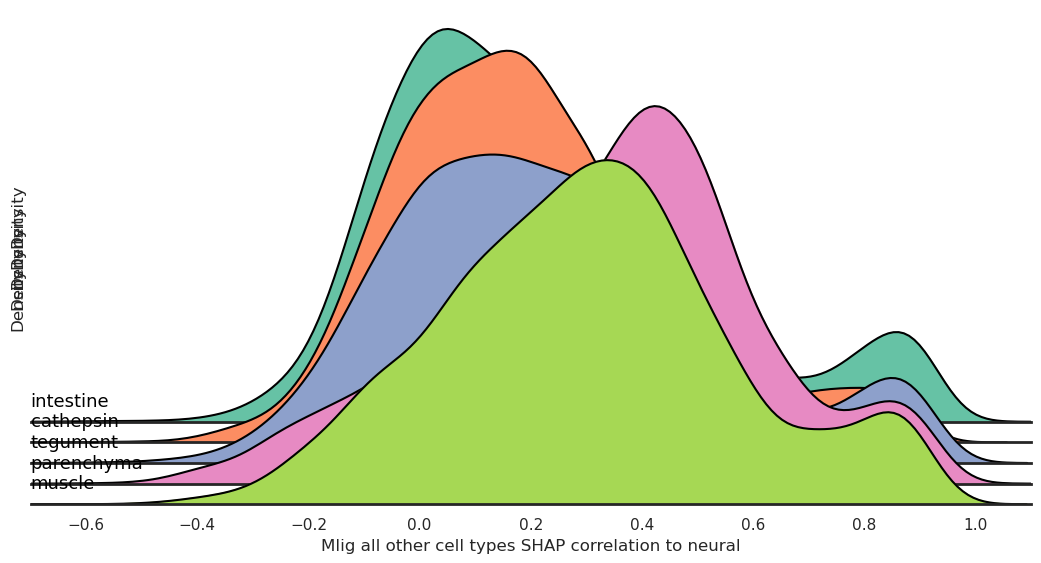

In [5]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2,'figure.figsize':(11,5)})
import matplotlib.pyplot as plt

palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_all, palette=palette, row="g", hue="g", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="x", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="x", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .05, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")
g.fig.subplots_adjust(hspace=-0.95)
g.set_titles("")
g.set(yticks=[], xlabel="Mlig all other cell types SHAP correlation to neural")
g.despine( left=True)
g.set(xlim=(-0.7, 1.1))

plt.savefig("./Plots/EDFig6/PanelED6b_1.svg", format="svg")

### muscle peaks

In [60]:
Mlig_muscle_onehot_seq = generate_onehot_sequences('./Refs/Mlig_4_5.v5/Mlig_4_5.fa',muscle_peaks_summit)

(2452, 2114, 4)


In [62]:
## Doing predictions 
Mlig_neural = Mlig_neural.predict(Mlig_muscle_onehot_seq)
Mlig_cathepsin = Mlig_cathepsin.predict(Mlig_muscle_onehot_seq)
Mlig_epidermal = Mlig_epidermal.predict(Mlig_muscle_onehot_seq)
Mlig_intestine = Mlig_intestine.predict(Mlig_muscle_onehot_seq)
Mlig_muscle = Mlig_muscle.predict(Mlig_muscle_onehot_seq)
Mlig_parenchyma = Mlig_parenchyma.predict(Mlig_muscle_onehot_seq)

/opt/conda/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [63]:
Mlig_neural_logits, Mlig_neural_counts = Mlig_neural
Mlig_cathepsin_logits, Mlig_cathepsin_counts = Mlig_cathepsin
Mlig_epidermal_logits, Mlig_epidermal_counts = Mlig_epidermal
Mlig_intestine_logits, Mlig_intestine_counts = Mlig_intestine
Mlig_muscle_logits, Mlig_muscle_counts = Mlig_muscle
Mlig_parenchyma_logits, Mlig_parenchyma_counts = Mlig_parenchyma

Mlig_neural_probs = softmax(Mlig_neural_logits) # Mlig neural
Mlig_cathepsin_probs = softmax(Mlig_cathepsin_logits) # Mlig cathepsin 
Mlig_epidermal_probs = softmax(Mlig_epidermal_logits) # Mlig epidermal
Mlig_intestine_probs = softmax(Mlig_intestine_logits) # Mlig intestine
Mlig_muscle_probs = softmax(Mlig_muscle_logits) # Mlig muscle
Mlig_parenchyma_probs = softmax(Mlig_parenchyma_logits) # Mlig parenchyma


In [46]:
# Calcuating correlation for profile 
corr_neural_profile = calculate_correlations(Mlig_muscle_probs,Mlig_neural_probs)
corr_intestine_profile = calculate_correlations(Mlig_muscle_probs, Mlig_intestine_probs)
corr_cathepsin_profile = calculate_correlations(Mlig_muscle_probs, Mlig_cathepsin_probs)
corr_epidermal_profile = calculate_correlations(Mlig_muscle_probs, Mlig_epidermal_probs)
corr_parenchyma_profile = calculate_correlations(Mlig_muscle_probs, Mlig_parenchyma_probs)

In [51]:
Mlig_neural_SHAP = compute_and_save_shap_scores(Mlig_neural, Mlig_muscle_onehot_seq)
Mlig_muscle_SHAP = compute_and_save_shap_scores(Mlig_muscle, Mlig_muscle_onehot_seq)
Mlig_intestine_SHAP = compute_and_save_shap_scores(Mlig_intestine, Mlig_muscle_onehot_seq)
Mlig_cathepsin_SHAP = compute_and_save_shap_scores(Mlig_cathepsin, Mlig_muscle_onehot_seq)
Mlig_epidermal_SHAP = compute_and_save_shap_scores(Mlig_epidermal, Mlig_muscle_onehot_seq)
Mlig_parenchyma_SHAP = compute_and_save_shap_scores(Mlig_parenchyma, Mlig_muscle_onehot_seq)

In [52]:
Mlig_corr_neural_SHAP = calculate_correlations(Mlig_muscle_SHAP, Mlig_neural_SHAP)
Mlig_corr_intestine_SHAP = calculate_correlations(Mlig_muscle_SHAP, Mlig_intestine_SHAP)
Mlig_corr_cathepsin_SHAP = calculate_correlations(Mlig_muscle_SHAP, Mlig_cathepsin_SHAP)
Mlig_corr_epidermal_SHAP= calculate_correlations(Mlig_muscle_SHAP, Mlig_epdiermal_SHAP)
Mlig_corr_parenchyma_SHAP= calculate_correlations(Mlig_muscle_SHAP, Mlig_parenchyma_SHAP)

In [136]:
neural_df = pd.DataFrame(data=Mlig_corr_neural_SHAP)
neural_df['g'] = 'neural'
neural_df.columns = ['x','g']

intestine_df = pd.DataFrame(data=Mlig_corr_intestine_SHAP)
intestine_df['g'] = 'intestine'
intestine_df.columns = ['x','g']

cathepsin_df = pd.DataFrame(data=Mlig_corr_cathepsin_SHAP)
cathepsin_df['g'] = 'cathepsin'
cathepsin_df.columns = ['x','g']

tegument_df = pd.DataFrame(data=Mlig_corr_epidermal_SHAP)
tegument_df['g'] = 'tegument'
tegument_df.columns = ['x','g']

parenchyma_df = pd.DataFrame(data=Mlig_corr_parenchyma_SHAP)
parenchyma_df['g'] = 'parenchyma'
parenchyma_df.columns = ['x','g']

df_all = [tegument_df, cathepsin_df, intestine_df,parenchyma_df, neural_df]
df_all = pd.concat(df_all,axis=0)
df_all

,x,g
0,-0.071779,tegument
1,-0.111153,tegument
2,0.185080,tegument
3,0.067817,tegument
4,0.037455,tegument
...,...,...
6991,0.332445,muscle
6992,0.395546,muscle
6993,0.190751,muscle
6994,0.002340,muscle


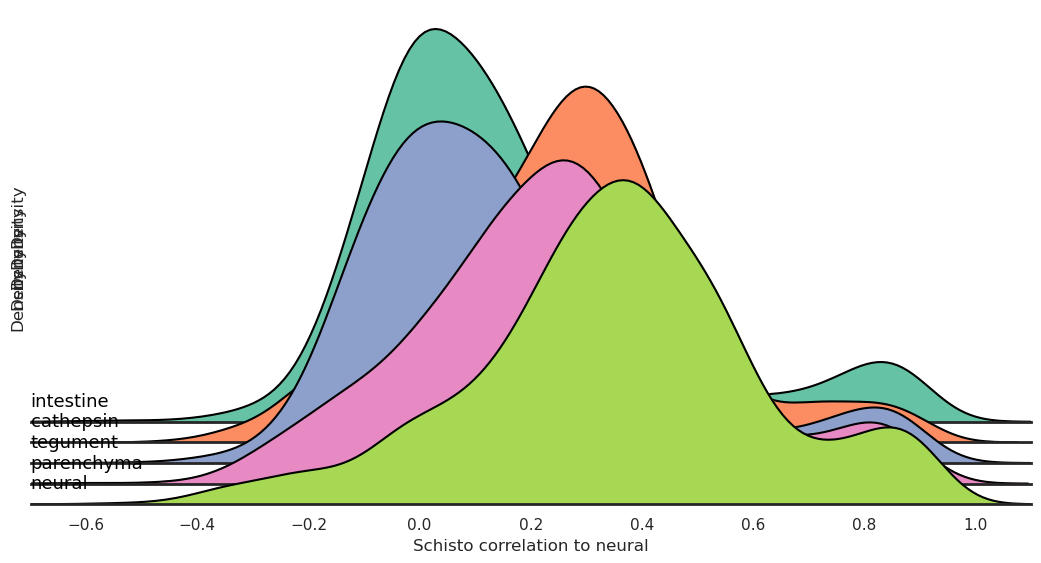

In [47]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2,'figure.figsize':(11,5)})
import matplotlib.pyplot as plt

palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_all, palette=palette, row="g", hue="g", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="x", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="x", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .05, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")
g.fig.subplots_adjust(hspace=-0.95)
g.set_titles("")
g.set(yticks=[], xlabel="Schisto correlation to neural")
g.despine( left=True)
g.set(xlim=(-0.7, 1.1))

plt.savefig("./Plots/EDFig6/PanelED6b_2.svg", format="svg")

## S. mediterranea

In [13]:
### Here, let's first load up all the neural peaks that we would need 
neural_peaks = pd.read_csv("./ChromBPNet/Peaks/pl_Neural_final_updated.csv",index_col=0)
muscle_peaks = pd.read_csv("./ChromBPNet/Peaks/pl_Muscle_final.csv",index_col=0)
overlap = intersection(muscle_peaks.Peak, neural_peaks.Peak) 
neural_peaks= neural_peaks[~neural_peaks.Peak.isin(overlap)]
muscle_peaks = muscle_peaks[~muscle_peaks.Peak.isin(overlap)]

In [14]:
neural_peaks[['chr', 'start', 'end']] = neural_peaks['Peak'].str.split(':|-', expand=True)
muscle_peaks[['chr', 'start', 'end']] = muscle_peaks['Peak'].str.split(':|-', expand=True)


In [15]:
### Here, I should add summit value so that I can do prediction 
allpeaks = pd.read_csv("./Peaks/Smed.merged_peaks.narrowPeak", sep="\t",header=None)
allpeaks.columns = ['chr','start','end','peak_index','score','strand','X','Y','Z','summit']
allpeaks =  allpeaks[['chr','start','end','summit']]
allpeaks['Peak'] = allpeaks.chr + ':' + (allpeaks.start+1).astype(str) + '-' + allpeaks.end.astype(str)
allpeaks['start'] = allpeaks['start']+1
allpeaks

,chr,start,end,summit,Peak
0,dd_Smes_g4_1,7590,7935,75,dd_Smes_g4_1:7590-7935
1,dd_Smes_g4_1,8523,9081,75,dd_Smes_g4_1:8523-9081
2,dd_Smes_g4_1,9261,9542,140,dd_Smes_g4_1:9261-9542
3,dd_Smes_g4_1,11180,11334,77,dd_Smes_g4_1:11180-11334
4,dd_Smes_g4_1,11397,11701,229,dd_Smes_g4_1:11397-11701
...,...,...,...,...,...
317483,dd_Smes_g4_99,2442858,2443360,84,dd_Smes_g4_99:2442858-2443360
317484,dd_Smes_g4_99,2444200,2444348,70,dd_Smes_g4_99:2444200-2444348
317485,dd_Smes_g4_99,2446643,2446791,69,dd_Smes_g4_99:2446643-2446791
317486,dd_Smes_g4_99,2448389,2448551,81,dd_Smes_g4_99:2448389-2448551


In [16]:
neural_peaks_summit = pd.merge(neural_peaks,allpeaks,on=['Peak'],how='left')
muscle_peaks_summit = pd.merge(muscle_peaks,allpeaks,on=['Peak'],how='left')

neural_peaks_summit = neural_peaks_summit [['chr_y','start_y','end_y','summit','Peak','prob_da','effect_size']]
neural_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','Peak','prob_da','effect_size']
index = [3460] # neural
neural_peaks_summit= neural_peaks_summit.drop(index)

muscle_peaks_summit = muscle_peaks_summit [['chr_y','start_y','end_y','summit','Peak','prob_da','effect_size']]
muscle_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','Peak','prob_da','effect_size']


### neural peaks

In [18]:
Smed_neural_onehot_seq = generate_onehot_sequences('./Refs/dd_Smes_g4/final_dd_Smed_g4.fa',neural_peaks_summit)

(6177, 2114, 4)


In [19]:
## Doing predictions 
Smed_neural = Smed_neural.predict(Smed_neural_onehot_seq)
Smed_cathepsin = Smed_cathepsin.predict(Smed_neural_onehot_seq)
Smed_epidermal = Smed_epidermal.predict(Smed_neural_onehot_seq)
Smed_intestine = Smed_intestine.predict(Smed_neural_onehot_seq)
Smed_muscle = Smed_muscle.predict(Smed_neural_onehot_seq)
Smed_parenchyma = Smed_parenchyma.predict(Smed_neural_onehot_seq)

/opt/conda/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-08-05 21:30:18.301195: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


In [20]:
Smed_neural_logits, Smed_neural_counts = Smed_neural
Smed_cathepsin_logits, Smed_cathepsin_counts = Smed_cathepsin
Smed_epidermal_logits, Smed_epidermal_counts = Smed_epidermal
Smed_intestine_logits, Smed_intestine_counts = Smed_intestine
Smed_muscle_logits, Smed_muscle_counts = Smed_muscle
Smed_parenchyma_logits, Smed_parenchyma_counts = Smed_parenchyma

Smed_neural_probs = softmax(Smed_neural_logits) # Mlig neural
Smed_cathepsin_probs = softmax(Smed_cathepsin_logits) # Mlig cathepsin 
Smed_epidermal_probs = softmax(Smed_epidermal_logits) # Mlig epidermal
Smed_intestine_probs = softmax(Smed_intestine_logits) # Mlig intestine
Smed_muscle_probs = softmax(Smed_muscle_logits) # Mlig muscle
Smed_parenchyma_probs = softmax(Smed_parenchyma_logits) # Mlig parenchyma

In [21]:
# Calcuating correlation for profile 
corr_muscle_profile = calculate_correlations(Smed_neural_probs,Smed_muscle_probs)
corr_intestine_profile = calculate_correlations(Smed_neural_probs, Smed_intestine_probs)
corr_cathepsin_profile = calculate_correlations(Smed_neural_probs, Smed_cathepsin_probs)
corr_epidermal_profile = calculate_correlations(Smed_neural_probs, Smed_epidermal_probs)
corr_parenchyma_profile = calculate_correlations(Smed_neural_probs, Smed_parenchyma_probs)

In [51]:
Smed_neural_SHAP = compute_and_save_shap_scores(Smed_neural, Smed_neural_onehot_seq)
Smed_muscle_SHAP = compute_and_save_shap_scores(Smed_muscle, Smed_neural_onehot_seq)
Smed_intestine_SHAP = compute_and_save_shap_scores(Smed_intestine, Smed_neural_onehot_seq)
Smed_cathepsin_SHAP = compute_and_save_shap_scores(Smed_cathepsin, Smed_neural_onehot_seq)
Smed_epidermal_SHAP = compute_and_save_shap_scores(Smed_epidermal, Smed_neural_onehot_seq)
Smed_parenchyma_SHAP = compute_and_save_shap_scores(Smed_parenchyma, Smed_neural_onehot_seq)

In [52]:
Smed_corr_muscle_SHAP = calculate_correlations(Smed_neural_SHAP, Smed_muscle_SHAP)
Smed_corr_intestine_SHAP = calculate_correlations(Smed_neural_SHAP, Smed_intestine_SHAP)
Smed_corr_cathepsin_SHAP = calculate_correlations(Smed_neural_SHAP, Smed_cathepsin_SHAP)
Smed_corr_epidermal_SHAP= calculate_correlations(Smed_neural_SHAP, Smed_epdiermal_SHAP)
Smed_corr_parenchyma_SHAP= calculate_correlations(Smed_neural_SHAP, Smed_parenchyma_SHAP)

In [136]:
muscle_df = pd.DataFrame(data=Smed_corr_muscle_SHAP)
muscle_df['g'] = 'muscle'
muscle_df.columns = ['x','g']

intestine_df = pd.DataFrame(data=Smed_corr_intestine_SHAP)
intestine_df['g'] = 'intestine'
intestine_df.columns = ['x','g']

cathepsin_df = pd.DataFrame(data=Smed_corr_cathepsin_SHAP)
cathepsin_df['g'] = 'cathepsin'
cathepsin_df.columns = ['x','g']

epidermal_df = pd.DataFrame(data=Smed_corr_epidermal_SHAP)
epidermal_df['g'] = 'epidermal'
epidermal_df.columns = ['x','g']

parenchyma_df = pd.DataFrame(data=Smed_corr_parenchyma_SHAP)
parenchyma_df['g'] = 'parenchyma'
parenchyma_df.columns = ['x','g']

df_all = [tegument_df, cathepsin_df, intestine_df,parenchyma_df, muscle_df]
df_all = pd.concat(df_all,axis=0)
df_all

,x,g
0,-0.071779,tegument
1,-0.111153,tegument
2,0.185080,tegument
3,0.067817,tegument
4,0.037455,tegument
...,...,...
6991,0.332445,muscle
6992,0.395546,muscle
6993,0.190751,muscle
6994,0.002340,muscle


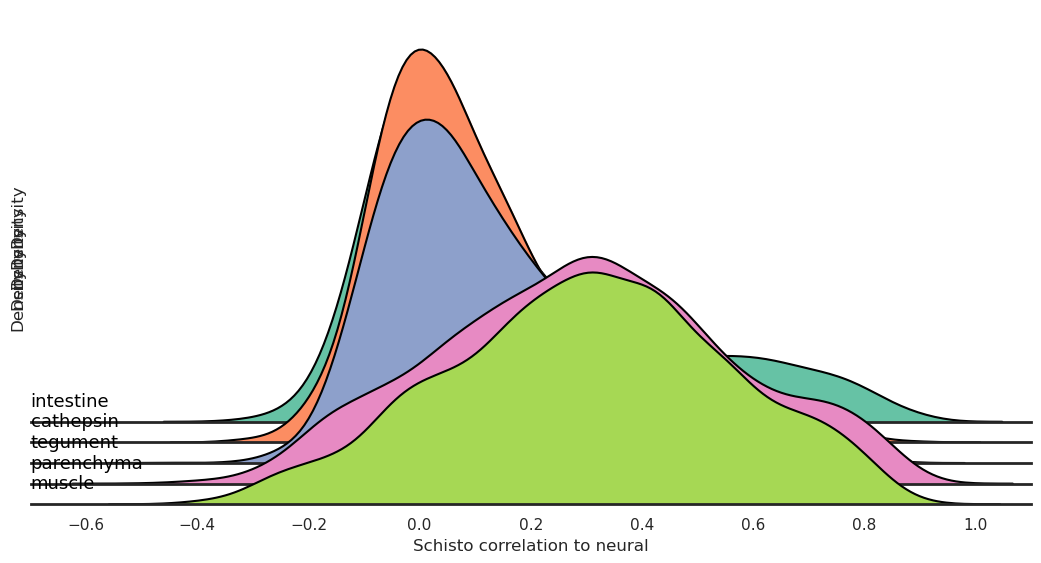

In [214]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2,'figure.figsize':(11,5)})
import matplotlib.pyplot as plt

palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_all, palette=palette, row="g", hue="g", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="x", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="x", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .05, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")
g.fig.subplots_adjust(hspace=-0.95)
g.set_titles("")
g.set(yticks=[], xlabel="Schisto correlation to neural")
g.despine( left=True)
g.set(xlim=(-0.7, 1.1))

plt.savefig("./Plots/EDFig6/PanelED6b_3.svg", format="svg")

### muscle peaks

In [27]:
Smed_muscle_onehot_seq = generate_onehot_sequences('./Refs/dd_Smes_g4/final_dd_Smed_g4.fa',muscle_peaks_summit)

(2493, 2114, 4)


In [28]:
## Doing predictions 
Smed_neural = Smed_neural.predict(Smed_muscle_onehot_seq)
Smed_cathepsin = Smed_cathepsin.predict(Smed_muscle_onehot_seq)
Smed_epidermal = Smed_epidermal.predict(Smed_muscle_onehot_seq)
Smed_intestine = Smed_intestine.predict(Smed_muscle_onehot_seq)
Smed_muscle = Smed_muscle.predict(Smed_muscle_onehot_seq)
Smed_parenchyma = Smed_parenchyma.predict(Smed_muscle_onehot_seq)

In [29]:
Smed_neural_logits, Smed_neural_counts = Smed_neural
Smed_cathepsin_logits, Smed_cathepsin_counts = Smed_cathepsin
Smed_epidermal_logits, Smed_epidermal_counts = Smed_epidermal
Smed_intestine_logits, Smed_intestine_counts = Smed_intestine
Smed_muscle_logits, Smed_muscle_counts = Smed_muscle
Smed_parenchyma_logits, Smed_parenchyma_counts = Smed_parenchyma

Smed_neural_probs = softmax(Smed_neural_logits) # Mlig neural
Smed_cathepsin_probs = softmax(Smed_cathepsin_logits) # Mlig cathepsin 
Smed_epidermal_probs = softmax(Smed_epidermal_logits) # Mlig epidermal
Smed_intestine_probs = softmax(Smed_intestine_logits) # Mlig intestine
Smed_muscle_probs = softmax(Smed_muscle_logits) # Mlig muscle
Smed_parenchyma_probs = softmax(Smed_parenchyma_logits) # Mlig parenchyma

In [30]:
# Calcuating correlation for profile 
corr_neural_profile = calculate_correlations(Smed_muscle_probs,Smed_neural_probs)
corr_intestine_profile = calculate_correlations(Smed_muscle_probs, Smed_intestine_probs)
corr_cathepsin_profile = calculate_correlations(Smed_muscle_probs, Smed_cathepsin_probs)
corr_epidermal_profile = calculate_correlations(Smed_muscle_probs, Smed_epidermal_probs)
corr_parenchyma_profile = calculate_correlations(Smed_muscle_probs, Smed_parenchyma_probs)

In [33]:
Smed_neural_SHAP = compute_and_save_shap_scores(Smed_neural, Smed_muscle_onehot_seq)
Smed_muscle_SHAP = compute_and_save_shap_scores(Smed_muscle, Smed_muscle_onehot_seq)
Smed_intestine_SHAP = compute_and_save_shap_scores(Smed_intestine, Smed_muscle_onehot_seq)
Smed_cathepsin_SHAP = compute_and_save_shap_scores(Smed_cathepsin, Smed_muscle_onehot_seq)
Smed_epidermal_SHAP = compute_and_save_shap_scores(Smed_epidermal, Smed_muscle_onehot_seq)
Smed_parenchyma_SHAP = compute_and_save_shap_scores(Smed_parenchyma, Smed_muscle_onehot_seq)


Done 0 examples of 2493



KeyboardInterrupt



In [52]:
Smed_corr_neural_SHAP = calculate_correlations(Smed_muscle_SHAP, Smed_neural_SHAP)
Smed_corr_intestine_SHAP = calculate_correlations(Smed_muscle_SHAP, Smed_intestine_SHAP)
Smed_corr_cathepsin_SHAP = calculate_correlations(Smed_muscle_SHAP, Smed_cathepsin_SHAP)
Smed_corr_epidermal_SHAP= calculate_correlations(Smed_muscle_SHAP, Smed_epdiermal_SHAP)
Smed_corr_parenchyma_SHAP= calculate_correlations(Smed_muscle_SHAP, Smed_parenchyma_SHAP)

In [136]:
neural_df = pd.DataFrame(data=Smed_corr_neural_SHAP)
neural_df['g'] = 'neural'
neural_df.columns = ['x','g']

intestine_df = pd.DataFrame(data=Smed_corr_intestine_SHAP)
intestine_df['g'] = 'intestine'
intestine_df.columns = ['x','g']

cathepsin_df = pd.DataFrame(data=Smed_corr_cathepsin_SHAP)
cathepsin_df['g'] = 'cathepsin'
cathepsin_df.columns = ['x','g']

epidermal_df = pd.DataFrame(data=Smed_corr_epidermal_SHAP)
epidermal_df['g'] = 'epidermal'
epidermal_df.columns = ['x','g']

parenchyma_df = pd.DataFrame(data=Smed_corr_parenchyma_SHAP)
parenchyma_df['g'] = 'parenchyma'
parenchyma_df.columns = ['x','g']

df_all = [tegument_df, cathepsin_df, intestine_df,parenchyma_df, neural_df]
df_all = pd.concat(df_all,axis=0)
df_all

,x,g
0,-0.071779,tegument
1,-0.111153,tegument
2,0.185080,tegument
3,0.067817,tegument
4,0.037455,tegument
...,...,...
6991,0.332445,muscle
6992,0.395546,muscle
6993,0.190751,muscle
6994,0.002340,muscle


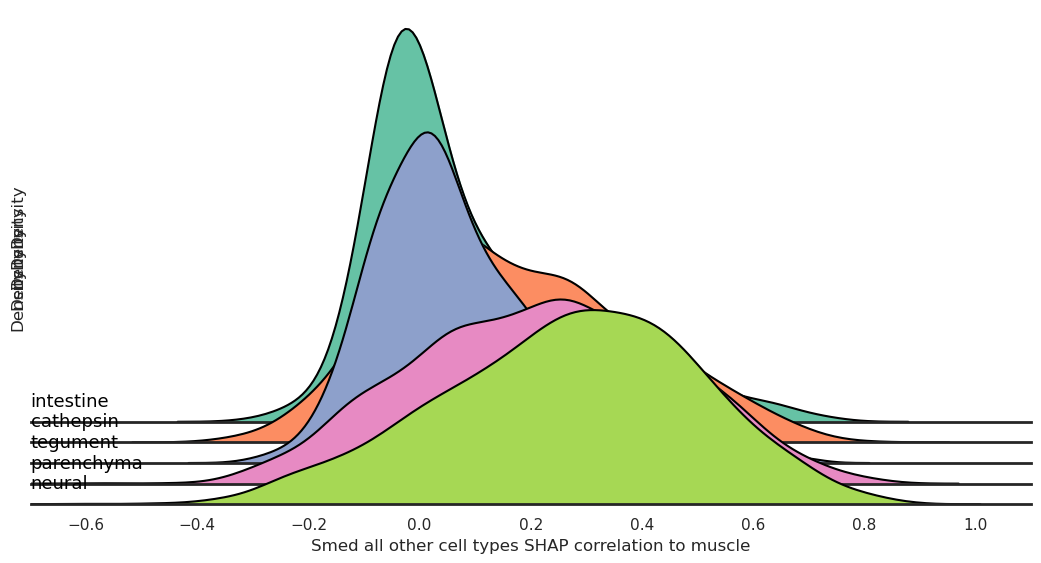

In [10]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2,'figure.figsize':(11,5)})
import matplotlib.pyplot as plt

palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_all, palette=palette, row="g", hue="g", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="x", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="x", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .05, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")
g.fig.subplots_adjust(hspace=-0.95)
g.set_titles("")
g.set(yticks=[], xlabel="Smed all other cell types SHAP correlation to muscle")
g.despine( left=True)
g.set(xlim=(-0.7, 1.1))

plt.savefig("./Plots/EDFig6/PanelED6b_4.svg", format="svg")

## S. mansoni

In [106]:
### Here, let's first load up all the neural peaks that we would need 
neural_peaks = pd.read_csv("./ChromBPNet/Peaks/schisto_Neural_final.csv",index_col=0)
muscle_peaks = pd.read_csv("./ChromBPNet/Peaks/schisto_Muscle_final.csv",index_col=0)
overlap = intersection(muscle_peaks.Peak, neural_peaks.Peak)
neural_peaks= neural_peaks[~neural_peaks.Peak.isin(overlap)]
muscle_peaks = muscle_peaks[~muscle_peaks.Peak.isin(overlap)] 

In [14]:
neural_peaks[['chr', 'start', 'end']] = neural_peaks['Peak'].str.split(':|-', expand=True)
muscle_peaks[['chr', 'start', 'end']] = muscle_peaks['Peak'].str.split(':|-', expand=True)

In [59]:
### Here, I should add summit value so that I can do prediction 
allpeaks = pd.read_csv("./Peaks/Sman.merged_peaks.narrowPeak", sep="\t",header=None)
allpeaks.columns = ['chr','start','end','peak_index','score','strand','X','Y','Z','summit']
allpeaks =  allpeaks[['chr','start','end','summit']]
allpeaks['Peak'] = allpeaks.chr + ':' + (allpeaks.start+1).astype(str) + '-' + allpeaks.end.astype(str)
allpeaks['start'] = allpeaks['start']+1
allpeaks

,chr,start,end,summit,Peak
0,SM_V7_1,32709,32858,74,SM_V7_1:32709-32858
1,SM_V7_1,54285,54746,75,SM_V7_1:54285-54746
2,SM_V7_1,90095,90244,101,SM_V7_1:90095-90244
3,SM_V7_1,99821,100158,237,SM_V7_1:99821-100158
4,SM_V7_1,126020,126404,264,SM_V7_1:126020-126404
...,...,...,...,...,...
163475,SM_V7_ZWU007,29156,29779,237,SM_V7_ZWU007:29156-29779
163476,SM_V7_ZWU007,29784,30038,112,SM_V7_ZWU007:29784-30038
163477,SM_V7_ZWU007,31397,31680,141,SM_V7_ZWU007:31397-31680
163478,SM_V7_ZWU007,31787,32486,466,SM_V7_ZWU007:31787-32486


In [16]:
neural_peaks_summit = pd.merge(neural_peaks,allpeaks,on=['Peak'],how='left')
muscle_peaks_summit = pd.merge(muscle_peaks,allpeaks,on=['Peak'],how='left')

neural_peaks_summit = neural_peaks_summit [['chr_y','start_y','end_y','summit','Peak','prob_da','effect_size']]
neural_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','Peak','prob_da','effect_size']
index = [395,6433]
neural_peaks_summit= neural_peaks_summit.drop(index)

muscle_peaks_summit = muscle_peaks_summit [['chr_y','start_y','end_y','summit','Peak','prob_da','effect_size']]
muscle_peaks_summit.columns = ['peak_chrom','peak_start','peak_end','summit','Peak','prob_da','effect_size']
index = [2406] # muscle 
muscle_peaks_summit= muscle_peaks_summit.drop(index)

### neural peaks

In [ ]:
Sman_neural_onehot_seq = generate_onehot_sequences('./Refs/SM_V7/Schisto_PRJEA36577.WBPS15.genomic.fa',neural_peaks_summit)

In [101]:
## Doing predictions 
Sman_neural = Sman_neural.predict(Sman_neural_onehot_seq)
Sman_cathepsin = Sman_cathepsin.predict(Sman_neural_onehot_seq)
Sman_intestine = Sman_intestine.predict(Sman_neural_onehot_seq)
Sman_muscle = Sman_muscle.predict(Sman_neural_onehot_seq)
Sman_tegument = Sman_tegument.predict(Sman_neural_onehot_seq)

/opt/conda/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,

KeyboardInterrupt



In [20]:
Sman_neural_logits, Sman_neural_counts = Sman_neural
Sman_cathepsin_logits, Sman_cathepsin_counts = Sman_cathepsin
Sman_epidermal_logits, Sman_epidermal_counts = Sman_epidermal
Sman_intestine_logits, Smab_intestine_counts = Sman_intestine
Sman_muscle_logits, Sman_muscle_counts = Sman_muscle
Sman_parenchyma_logits, Sman_parenchyma_counts = Sman_parenchyma

Sman_neural_probs = softmax(Sman_neural_logits) # Mlig neural
Sman_cathepsin_probs = softmax(Sman_cathepsin_logits) # Mlig cathepsin 
Sman_epidermal_probs = softmax(Sman_epidermal_logits) # Mlig epidermal
Sman_intestine_probs = softmax(Sman_intestine_logits) # Mlig intestine
Sman_muscle_probs = softmax(Sman_muscle_logits) # Mlig muscle
Sman_parenchyma_probs = softmax(Sman_parenchyma_logits) # Mlig parenchyma

In [21]:
# Calcuating correlation for profile 
corr_muscle_profile = calculate_correlations(Sman_neural_probs,Sman_muscle_probs)
corr_intestine_profile = calculate_correlations(Sman_neural_probs, Sman_intestine_probs)
corr_cathepsin_profile = calculate_correlations(Sman_neural_probs, Sman_cathepsin_probs)
corr_epidermal_profile = calculate_correlations(Sman_neural_probs, Sman_epidermal_probs)
corr_parenchyma_profile = calculate_correlations(Sman_neural_probs, Sman_parenchyma_probs)

In [51]:
Sman_neural_SHAP = compute_and_save_shap_scores(Sman_neural, Sman_neural_onehot_seq)
Sman_muscle_SHAP = compute_and_save_shap_scores(Sman_muscle, Sman_neural_onehot_seq)
Sman_intestine_SHAP = compute_and_save_shap_scores(Sman_intestine, Sman_neural_onehot_seq)
Sman_cathepsin_SHAP = compute_and_save_shap_scores(Sman_cathepsin, Sman_neural_onehot_seq)
Sman_epidermal_SHAP = compute_and_save_shap_scores(Sman_epidermal, Sman_neural_onehot_seq)
Sman_parenchyma_SHAP = compute_and_save_shap_scores(Sman_parenchyma, Sman_neural_onehot_seq)

In [52]:
Sman_corr_muscle_SHAP = calculate_correlations(Sman_neural_SHAP, Sman_muscle_SHAP)
Sman_corr_intestine_SHAP = calculate_correlations(Sman_neural_SHAP, Sman_intestine_SHAP)
Sman_corr_cathepsin_SHAP = calculate_correlations(Sman_neural_SHAP, Sman_cathepsin_SHAP)
Sman_corr_epidermal_SHAP= calculate_correlations(Sman_neural_SHAP, Sman_epdiermal_SHAP)
Sman_corr_parenchyma_SHAP= calculate_correlations(Sman_neural_SHAP, Sman_parenchyma_SHAP)

In [136]:
muscle_df = pd.DataFrame(data=Sman_corr_muscle_SHAP)
muscle_df['g'] = 'muscle'
muscle_df.columns = ['x','g']

intestine_df = pd.DataFrame(data=Sman_corr_intestine_SHAP)
intestine_df['g'] = 'intestine'
intestine_df.columns = ['x','g']

cathepsin_df = pd.DataFrame(data=Sman_corr_cathepsin_SHAP)
cathepsin_df['g'] = 'cathepsin'
cathepsin_df.columns = ['x','g']

epidermal_df = pd.DataFrame(data=Sman_corr_epidermal_SHAP)
epidermal_df['g'] = 'epidermal'
epidermal_df.columns = ['x','g']

parenchyma_df = pd.DataFrame(data=Sman_corr_parenchyma_SHAP)
parenchyma_df['g'] = 'parenchyma'
parenchyma_df.columns = ['x','g']

df_all = [tegument_df, cathepsin_df, intestine_df,parenchyma_df, muscle_df]
df_all = pd.concat(df_all,axis=0)
df_all

,x,g
0,-0.071779,tegument
1,-0.111153,tegument
2,0.185080,tegument
3,0.067817,tegument
4,0.037455,tegument
...,...,...
6991,0.332445,muscle
6992,0.395546,muscle
6993,0.190751,muscle
6994,0.002340,muscle


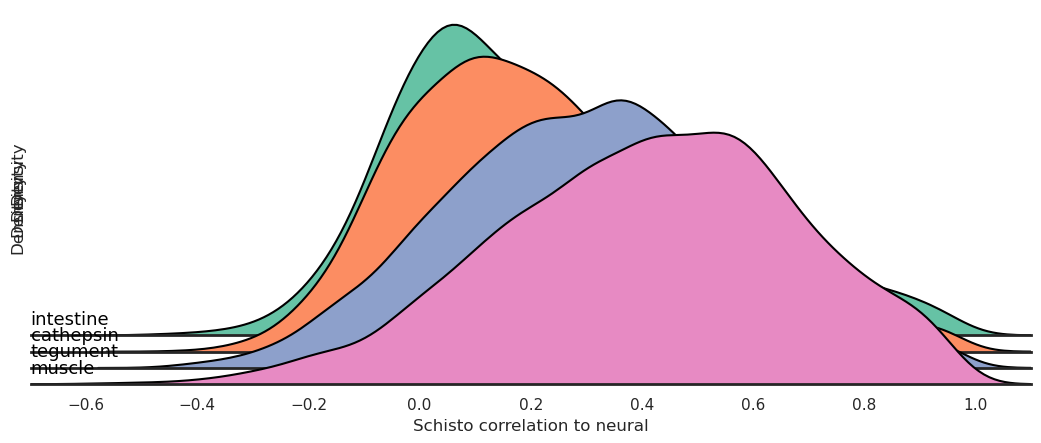

In [47]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2,'figure.figsize':(11,5)})
import matplotlib.pyplot as plt

palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_all, palette=palette, row="g", hue="g", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="x", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="x", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .05, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")
g.fig.subplots_adjust(hspace=-0.95)
g.set_titles("")
g.set(yticks=[], xlabel="Schisto correlation to neural")
g.despine( left=True)
g.set(xlim=(-0.7, 1.1))

plt.savefig("./Plots/EDFig6/PanelED6b_5.svg", format="svg")

### muscle peaks

In [27]:
Sman_muscle_onehot_seq = generate_onehot_sequences('./Refs/SM_V7/Schisto_PRJEA36577.WBPS15.genomic.fa',muscle_peaks_summit)

(2493, 2114, 4)


In [28]:
## Doing predictions 
Sman_neural = Sman_neural.predict(Sman_muscle_onehot_seq)
Sman_cathepsin = Sman_cathepsin.predict(Sman_muscle_onehot_seq)
Sman_epidermal = Sman_epidermal.predict(Sman_muscle_onehot_seq)
Sman_intestine = Sman_intestine.predict(Sman_muscle_onehot_seq)
Sman_muscle = Sman_muscle.predict(Sman_muscle_onehot_seq)
Sman_parenchyma = Sman_parenchyma.predict(Sman_muscle_onehot_seq)

In [29]:
Sman_neural_logits, Sman_neural_counts = Sman_neural
Sman_cathepsin_logits, Sman_cathepsin_counts = Sman_cathepsin
Sman_epidermal_logits, Sman_epidermal_counts = Sman_epidermal
Sman_intestine_logits, Sman_intestine_counts = Sman_intestine
Sman_muscle_logits, Sman_muscle_counts = Sman_muscle
Sman_parenchyma_logits, Sman_parenchyma_counts = Sman_parenchyma

Sman_neural_probs = softmax(Sman_neural_logits) # Mlig neural
Sman_cathepsin_probs = softmax(Sman_cathepsin_logits) # Mlig cathepsin 
Sman_epidermal_probs = softmax(Sman_epidermal_logits) # Mlig epidermal
Sman_intestine_probs = softmax(Sman_intestine_logits) # Mlig intestine
Sman_muscle_probs = softmax(Sman_muscle_logits) # Mlig muscle
Sman_parenchyma_probs = softmax(Sman_parenchyma_logits) # Mlig parenchyma

In [30]:
# Calcuating correlation for profile 
corr_neural_profile = calculate_correlations(Sman_muscle_probs,Sman_neural_probs)
corr_intestine_profile = calculate_correlations(Sman_muscle_probs, Sman_intestine_probs)
corr_cathepsin_profile = calculate_correlations(Sman_muscle_probs, Sman_cathepsin_probs)
corr_epidermal_profile = calculate_correlations(Sman_muscle_probs, Sman_epidermal_probs)
corr_parenchyma_profile = calculate_correlations(Sman_muscle_probs, Sman_parenchyma_probs)

In [33]:
Sman_neural_SHAP = compute_and_save_shap_scores(Sman_neural, Sman_muscle_onehot_seq)
Sman_muscle_SHAP = compute_and_save_shap_scores(Sman_muscle, Sman_muscle_onehot_seq)
Sman_intestine_SHAP = compute_and_save_shap_scores(Sman_intestine, Sman_muscle_onehot_seq)
Sman_cathepsin_SHAP = compute_and_save_shap_scores(Sman_cathepsin, Sman_muscle_onehot_seq)
Sman_epidermal_SHAP = compute_and_save_shap_scores(Sman_epidermal, Sman_muscle_onehot_seq)
Sman_parenchyma_SHAP = compute_and_save_shap_scores(Sman_parenchyma, Sman_muscle_onehot_seq)


Done 0 examples of 2493



KeyboardInterrupt



In [52]:
Sman_corr_neural_SHAP = calculate_correlations(Sman_muscle_SHAP, Sman_neural_SHAP)
Sman_corr_intestine_SHAP = calculate_correlations(Sman_muscle_SHAP, Sman_intestine_SHAP)
Sman_corr_cathepsin_SHAP = calculate_correlations(Sman_muscle_SHAP, Sman_cathepsin_SHAP)
Sman_corr_epidermal_SHAP= calculate_correlations(Sman_muscle_SHAP, Sman_epdiermal_SHAP)
Sman_corr_parenchyma_SHAP= calculate_correlations(Smam_muscle_SHAP, Sman_parenchyma_SHAP)

In [136]:
neural_df = pd.DataFrame(data=Sman_corr_neural_SHAP)
neural_df['g'] = 'neural'
neural_df.columns = ['x','g']

intestine_df = pd.DataFrame(data=Sman_corr_intestine_SHAP)
intestine_df['g'] = 'intestine'
intestine_df.columns = ['x','g']

cathepsin_df = pd.DataFrame(data=Sman_corr_cathepsin_SHAP)
cathepsin_df['g'] = 'cathepsin'
cathepsin_df.columns = ['x','g']

epidermal_df = pd.DataFrame(data=Sman_corr_epidermal_SHAP)
epidermal_df['g'] = 'epidermal'
epidermal_df.columns = ['x','g']

parenchyma_df = pd.DataFrame(data=Sman_corr_parenchyma_SHAP)
parenchyma_df['g'] = 'parenchyma'
parenchyma_df.columns = ['x','g']

df_all = [tegument_df, cathepsin_df, intestine_df,parenchyma_df, neural_df]
df_all = pd.concat(df_all,axis=0)
df_all

,x,g
0,-0.071779,tegument
1,-0.111153,tegument
2,0.185080,tegument
3,0.067817,tegument
4,0.037455,tegument
...,...,...
6991,0.332445,muscle
6992,0.395546,muscle
6993,0.190751,muscle
6994,0.002340,muscle


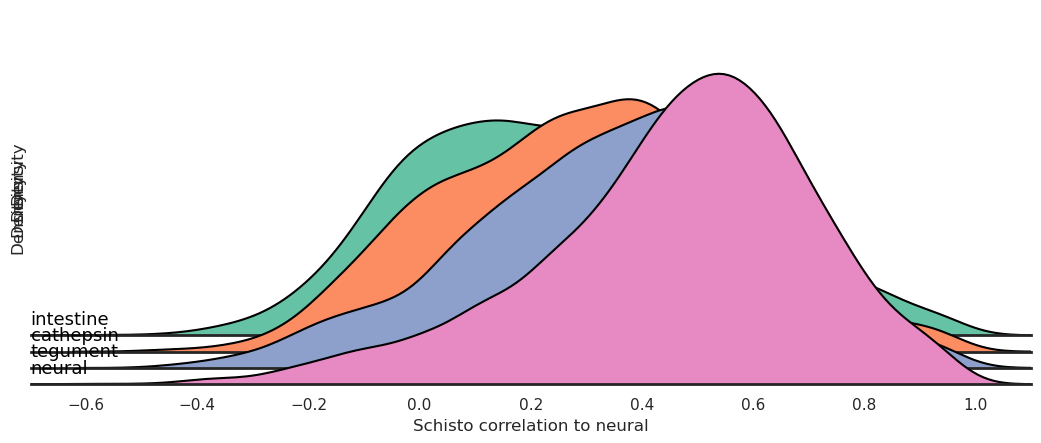

In [239]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2,'figure.figsize':(11,5)})
import matplotlib.pyplot as plt

palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(df_all, palette=palette, row="g", hue="g", aspect=9, height=1.2)
g.map_dataframe(sns.kdeplot, x="x", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="x", color='black')
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .05, label, color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")
g.fig.subplots_adjust(hspace=-0.95)
g.set_titles("")
g.set(yticks=[], xlabel="Schisto correlation to neural")
g.despine( left=True)
g.set(xlim=(-0.7, 1.1))

plt.savefig("./Plots/EDFig6/PanelED6b_6.svg", format="svg")